In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

#scale back to the true range
def true_range(df, x):
    X = (x * (df['mid1'].max() - df['mid1'].min())) + df['mid1'].min()
    return X

#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#rolling windows
def train_windows(df, ref_day=10, predict_day=5):
    X_train, Y_train = [], []
    for i in range(int(df.shape[0] / 5 - 2)):
        #扣掉response
        #記得最後一行要放response
        #if i == df.shape[0]-predict_day-ref_day -1:
        #    X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        #    Y_train.append(np.array(df.iloc[i+ref_day:]["mid1"]))
        #else:  
        X_train.append(np.array(df.iloc[i * predict_day: predict_day * (i + 2),:-1]))
        Y_train.append(np.array(df.iloc[(i+2) * predict_day: (i+3) * predict_day]["mid1"]))
    return np.array(X_train), np.array(Y_train)

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    #10 -> X shape
    model.add(Dense(10,activation='linear'))
    #5 -> Y shape
    model.add(Dense(5,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)

In [3]:
def strategy(df_train, paras):
    #train
    transaction_history1 = {}
    equity_value_1 = pd.DataFrame()
    each_return1 = pd.DataFrame()
    unrealized_1 = pd.DataFrame()
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        for i in range(len(df)):
            #first tick, no signal
            if i == 0:
                df['holding'].iloc[i] = 0
                df['equity_value'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history1 = record_transaction(paras[0], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    #if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                    #    df['holding'].iloc[i] = 0
                    #    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    #    df['unrealized'].iloc[i] = 'realized'
                    #    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    if (df[paras].iloc[i-1] == -1): 
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    #if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                    #    df['holding'].iloc[i] = 0
                    #    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    #    df['unrealized'].iloc[i] = 'realized'
                    #    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    if (df['Ask1'].iloc[i] != 0) and (df[paras].iloc[i-1] == 1): 
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = 'realized'
                        transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
                elif df['holding'].iloc[i-1] == 0:
                    if (df[paras].iloc[i-1] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df[paras].iloc[i-1] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        unrealized1 = pd.concat([unrealized1, df['unrealized']])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)
    
    return equity_value_1, transaction_history1, each_return1, unrealized_1

In [3]:
df = pd.read_csv('./data/3406_2.csv')
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

In [5]:
#train_5t = pd.read_csv('./data/train_5t_2.csv')
#test_5t = pd.read_csv('./data/test_5t_2.csv')
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#test
df_test = df.iloc[372025: ]
#為了可以被5整除
df_train = df.iloc[0:372025]
#1~10 pred 11, hence start from 11
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
#reset index
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
#calculate pred return
#df_train['pred_mid'] = train_5t[['0']]
#df_train['mid_shift'] = df_train['pred_mid'].shift(1)
#df_test['pred_mid'] = test_5t[['0']]

In [127]:
df_train['short_qty'] = (df_train['AskQty1'] - df_train['BidQty1']) / (df_train['AskQty1'] + df_train['BidQty1'])
df_train['long_qty'] = (df_train['BidQty1'] - df_train['AskQty1']) / (df_train['AskQty1'] + df_train['BidQty1'])

In [6]:
#try MA(50)
df_train['MA'] = MA(df_train['mid1'], 50)
df_test['MA'] = MA(df_test['mid1'], 50)

In [7]:
df_train['side'] = df_train['mid1'] > df_train['MA']

In [8]:
df_train = df_train.dropna()
df_train = df_train.reset_index(drop = True)
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,MA,side
0,397.0,1,2,396.5,398.0,1,9,396.0,399.0,142,...,8.0,38.0,0.0,-39.0,397.25,0.0,0.0,0.0,398.000,False
1,0.0,0,2,396.5,398.0,1,9,396.0,399.0,142,...,8.0,38.0,7.0,-8.0,397.25,0.0,0.0,0.0,398.010,False
2,396.5,1,1,396.5,398.0,1,9,396.0,399.0,142,...,8.0,38.0,7.0,-8.0,397.25,0.0,0.0,0.0,398.020,False
3,398.0,1,1,396.5,399.0,142,9,396.0,399.5,6,...,8.0,38.0,7.0,-8.0,397.75,0.0,0.0,0.0,398.045,False
4,399.0,1,1,396.5,399.0,141,9,396.0,399.5,6,...,8.0,37.0,0.0,-39.0,397.75,0.0,0.0,0.0,398.070,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371961,444.5,1,7,444.0,445.0,26,11,443.5,445.5,9,...,-6.0,10.0,-9.0,9.0,444.50,0.0,0.0,0.0,444.305,True
371962,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,-6.0,10.0,-9.0,9.0,444.50,0.0,0.0,0.0,444.310,True
371963,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,0.0,0.0,0.0,0.0,444.50,0.0,0.0,0.0,444.315,True
371964,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,0.0,0.0,0.0,0.0,444.50,0.0,0.0,0.0,444.320,True


In [9]:
df_train['side'] = df_train['side'].astype(int)

In [10]:
df_train['p_acc_d'] = df_train['p_acc_diff'] > 25
df_train['p_acc_d'] = df_train['p_acc_d'].astype(int)
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,MA,side,p_acc_d
0,397.0,1,2,396.5,398.0,1,9,396.0,399.0,142,...,38.0,0.0,-39.0,397.25,0.0,0.0,0.0,398.000,0,0
1,0.0,0,2,396.5,398.0,1,9,396.0,399.0,142,...,38.0,7.0,-8.0,397.25,0.0,0.0,0.0,398.010,0,0
2,396.5,1,1,396.5,398.0,1,9,396.0,399.0,142,...,38.0,7.0,-8.0,397.25,0.0,0.0,0.0,398.020,0,0
3,398.0,1,1,396.5,399.0,142,9,396.0,399.5,6,...,38.0,7.0,-8.0,397.75,0.0,0.0,0.0,398.045,0,0
4,399.0,1,1,396.5,399.0,141,9,396.0,399.5,6,...,37.0,0.0,-39.0,397.75,0.0,0.0,0.0,398.070,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371961,444.5,1,7,444.0,445.0,26,11,443.5,445.5,9,...,10.0,-9.0,9.0,444.50,0.0,0.0,0.0,444.305,1,0
371962,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,10.0,-9.0,9.0,444.50,0.0,0.0,0.0,444.310,1,0
371963,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,0.0,0.0,0.0,444.50,0.0,0.0,0.0,444.315,1,0
371964,0.0,0,8,444.0,445.0,26,11,443.5,445.5,9,...,0.0,0.0,0.0,444.50,0.0,0.0,0.0,444.320,1,0


In [11]:
(df_train['p_acc_d'] == 1).sum()

345

In [12]:
((df_train['p_acc_d'] == 1) & (df_train['side'] == 0)).sum()

153

In [13]:
((df_train['p_acc_d'] == 1) & (df_train['side'] == 1)).sum()

192

In [14]:
df_train['action'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
for i in range(len(df_train)):
    if ((df_train['p_acc_d'].iloc[i] == 1) & (df_train['side'].iloc[i] == 0)):
        #long side
        df_train['action'].iloc[i] = 1
    elif ((df_train['p_acc_d'].iloc[i] == 1) & (df_train['side'].iloc[i] == 1)):
        #short side
        df_train['action'].iloc[i] = -1

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
(df_train['action'] == 1).sum()

153

In [16]:
(df_train['action'] == -1).sum()

192

In [17]:
df_test['side'] = df_test['mid1'] > df_test['MA']
df_test = df_test.dropna()
df_test = df_test.reset_index(drop = True)
df_test['side'] = df_test['side'].astype(int)
#25
df_test['p_acc_d'] = df_test['p_acc_diff'] > 25
df_test['p_acc_d'] = df_test['p_acc_d'].astype(int)
df_test['action'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
for i in range(len(df_test)):
    if ((df_test['p_acc_d'].iloc[i] == 1) & (df_test['side'].iloc[i] == 0)):
        #long side
        df_test['action'].iloc[i] = 1
    elif ((df_test['p_acc_d'].iloc[i] == 1) & (df_test['side'].iloc[i] == 1)):
        #short side
        df_test['action'].iloc[i] = -1

In [18]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq4_dt_10,dbq5_dt_10,mid1,equity_value,unrealized,holding,MA,side,p_acc_d,action
0,0.0,0,5,448.0,449.0,31,12,447.5,449.5,12,...,24.0,-10.0,448.50,0.0,0.0,0.0,447.930,1,0,0.0
1,0.0,0,5,448.0,449.0,32,12,447.5,449.5,12,...,24.0,-10.0,448.50,0.0,0.0,0.0,447.945,1,0,0.0
2,0.0,0,5,448.0,449.0,32,13,447.5,449.5,12,...,0.0,0.0,448.50,0.0,0.0,0.0,447.960,1,0,0.0
3,449.0,1,5,448.0,449.0,31,13,447.5,449.5,12,...,-74.0,-24.0,448.50,0.0,0.0,0.0,447.975,1,0,0.0
4,449.0,1,5,448.0,449.0,30,13,447.5,449.5,12,...,-74.0,-24.0,448.50,0.0,0.0,0.0,447.990,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121131,0.0,0,11,465.5,466.0,1,40,465.0,466.5,9,...,27.0,-65.0,465.75,0.0,0.0,0.0,465.680,1,0,0.0
121132,465.5,1,10,465.5,466.0,1,40,465.0,466.5,9,...,27.0,-65.0,465.75,0.0,0.0,0.0,465.675,1,0,0.0
121133,0.0,0,10,465.5,466.0,1,41,465.0,466.5,9,...,27.0,-65.0,465.75,0.0,0.0,0.0,465.670,1,0,0.0
121134,0.0,0,10,465.5,466.0,1,42,465.0,466.5,9,...,0.0,0.0,465.75,0.0,0.0,0.0,465.670,1,0,0.0


In [19]:
(df_test['action'] == 1).sum()

11

In [20]:
(df_test['action'] == -1).sum()

48

In [21]:
(df_test['p_acc_d'] == 1).sum()

59

In [22]:
paras = 'action'
equity_value_1, transaction_history1, each_return1, unrealized_1 = strategy(df_train, paras)

NameError: name 'strategy' is not defined

In [19]:
equity_value_1

,equity_value
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
371961,-0.004148
371962,-0.004148
371963,-0.004148
371964,-0.004148


# EDA

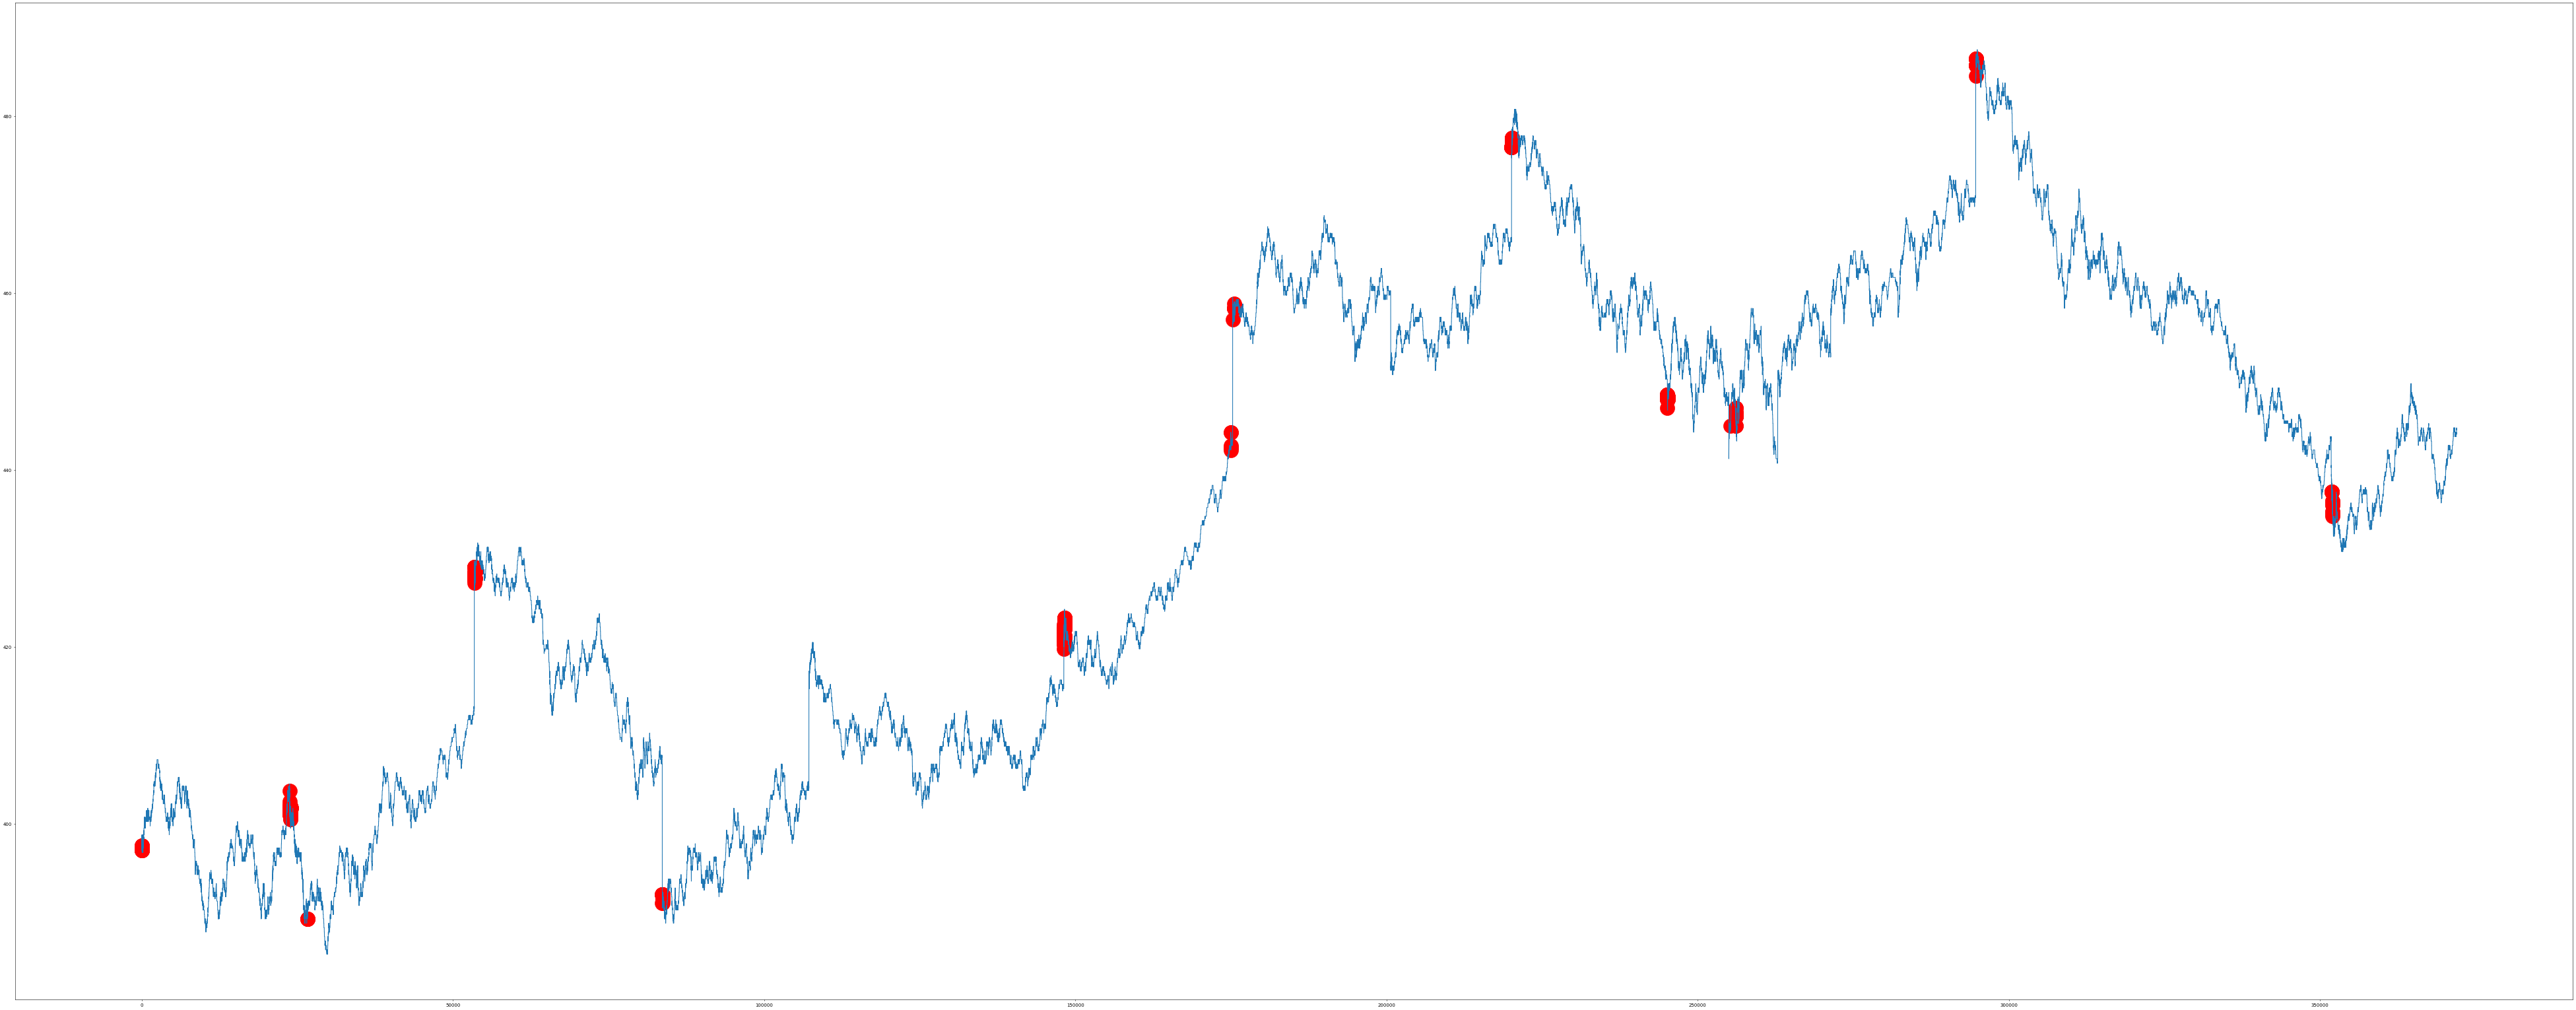

In [25]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_train['mid1'])
plt.scatter(df_train[df_train['p_acc_diff'] > 25].index.tolist(), df_train['mid1'][df_train[df_train['p_acc_diff'] > 25].index.tolist()], color = ['red'], s = 1000)

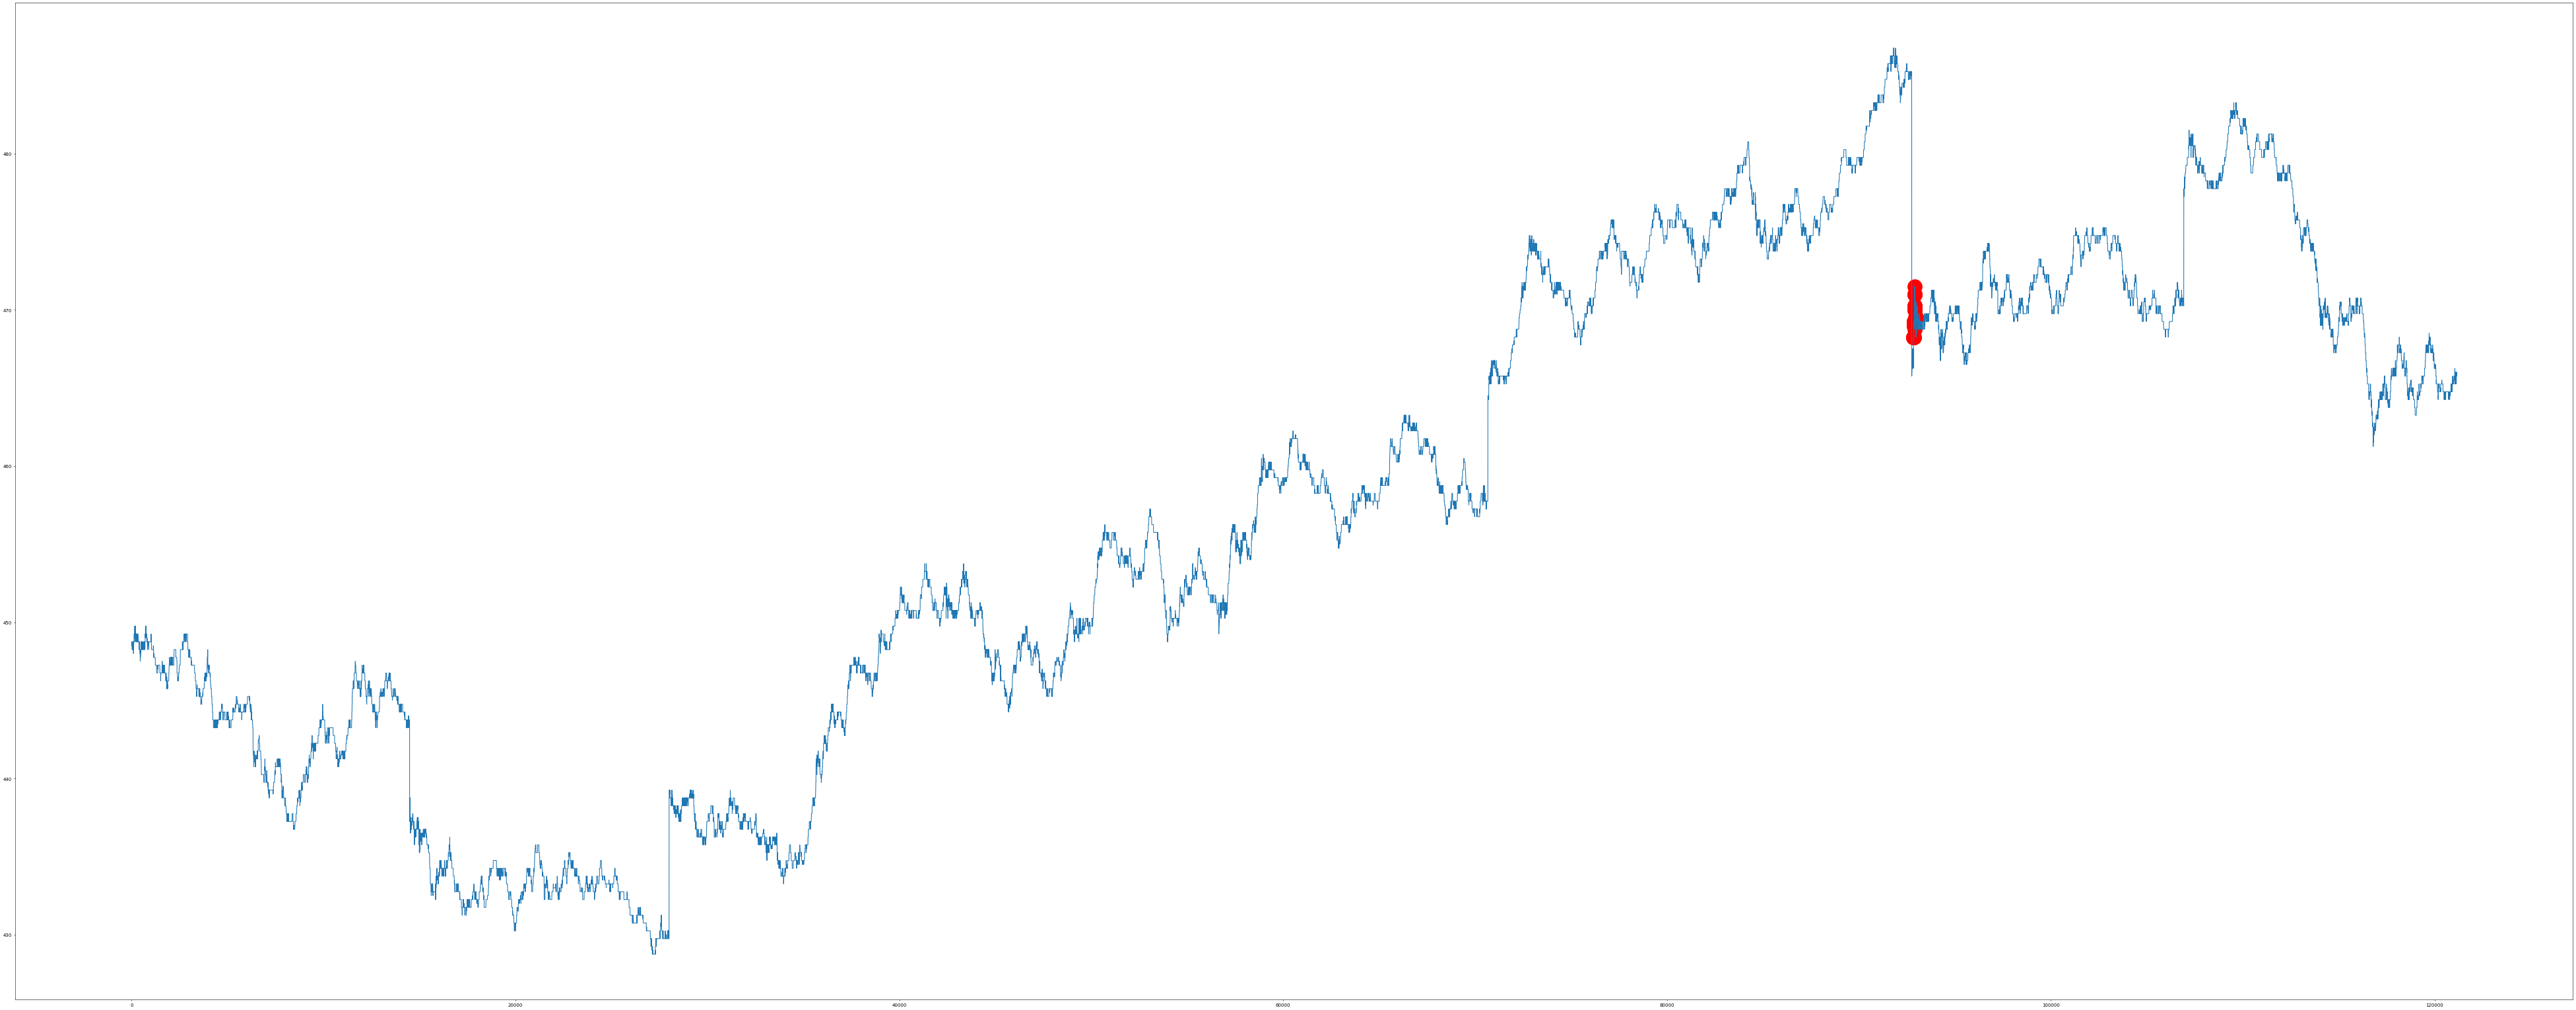

In [26]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test['mid1'])
plt.scatter(df_test[df_test['p_acc_diff'] > 25].index.tolist(), df_test['mid1'][df_test[df_test['p_acc_diff'] > 25].index.tolist()], color = ['red'], s = 1000)

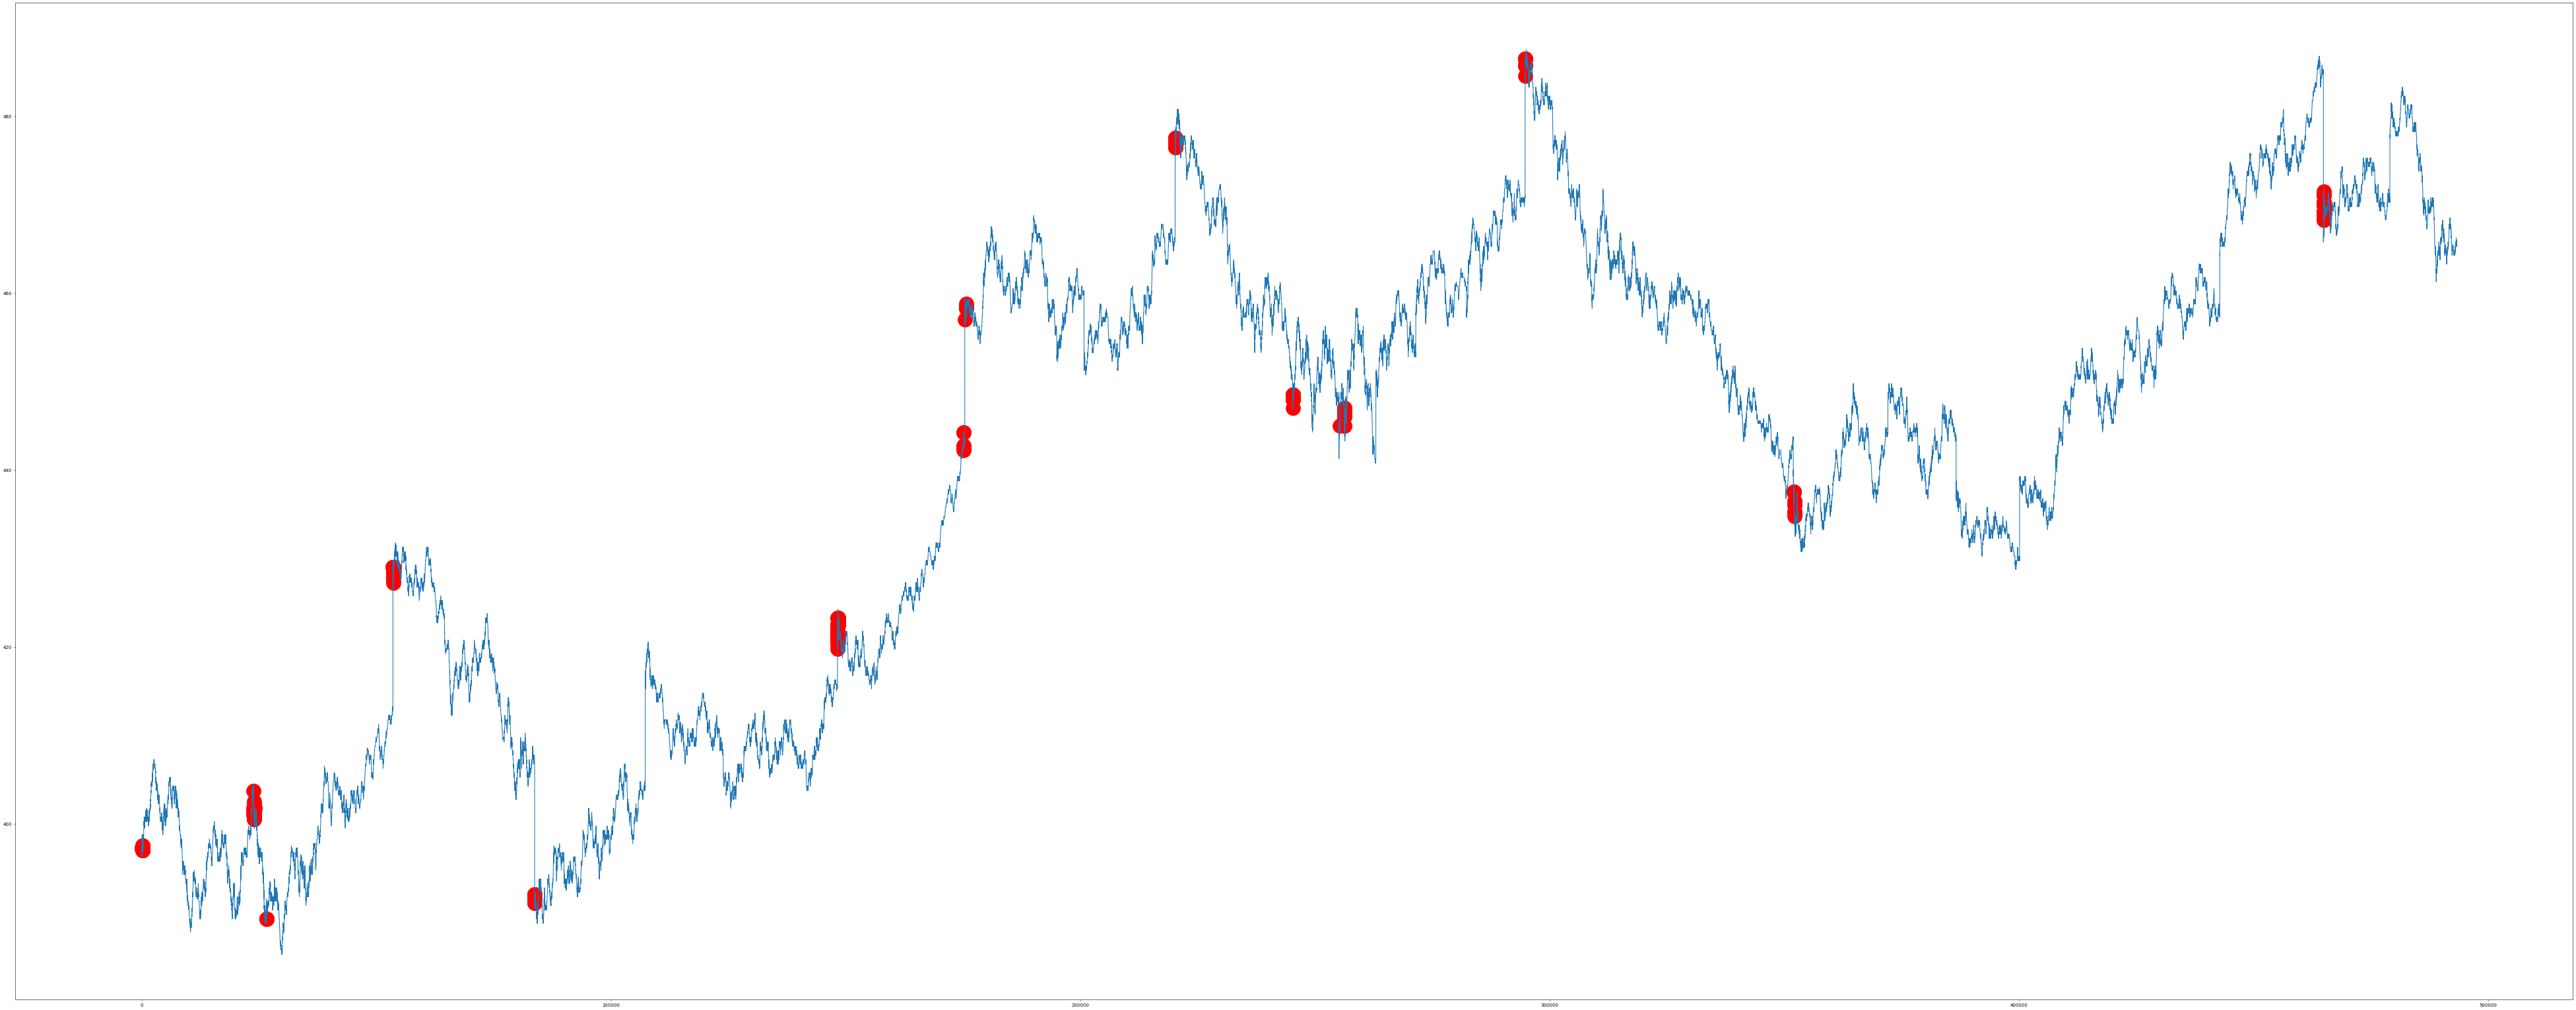

In [141]:
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df['mid1'])
plt.scatter(df[df['p_acc_diff'] > 25].index.tolist(), df['mid1'][df[df['p_acc_diff'] > 25].index.tolist()], color = ['red'], s = 1000)

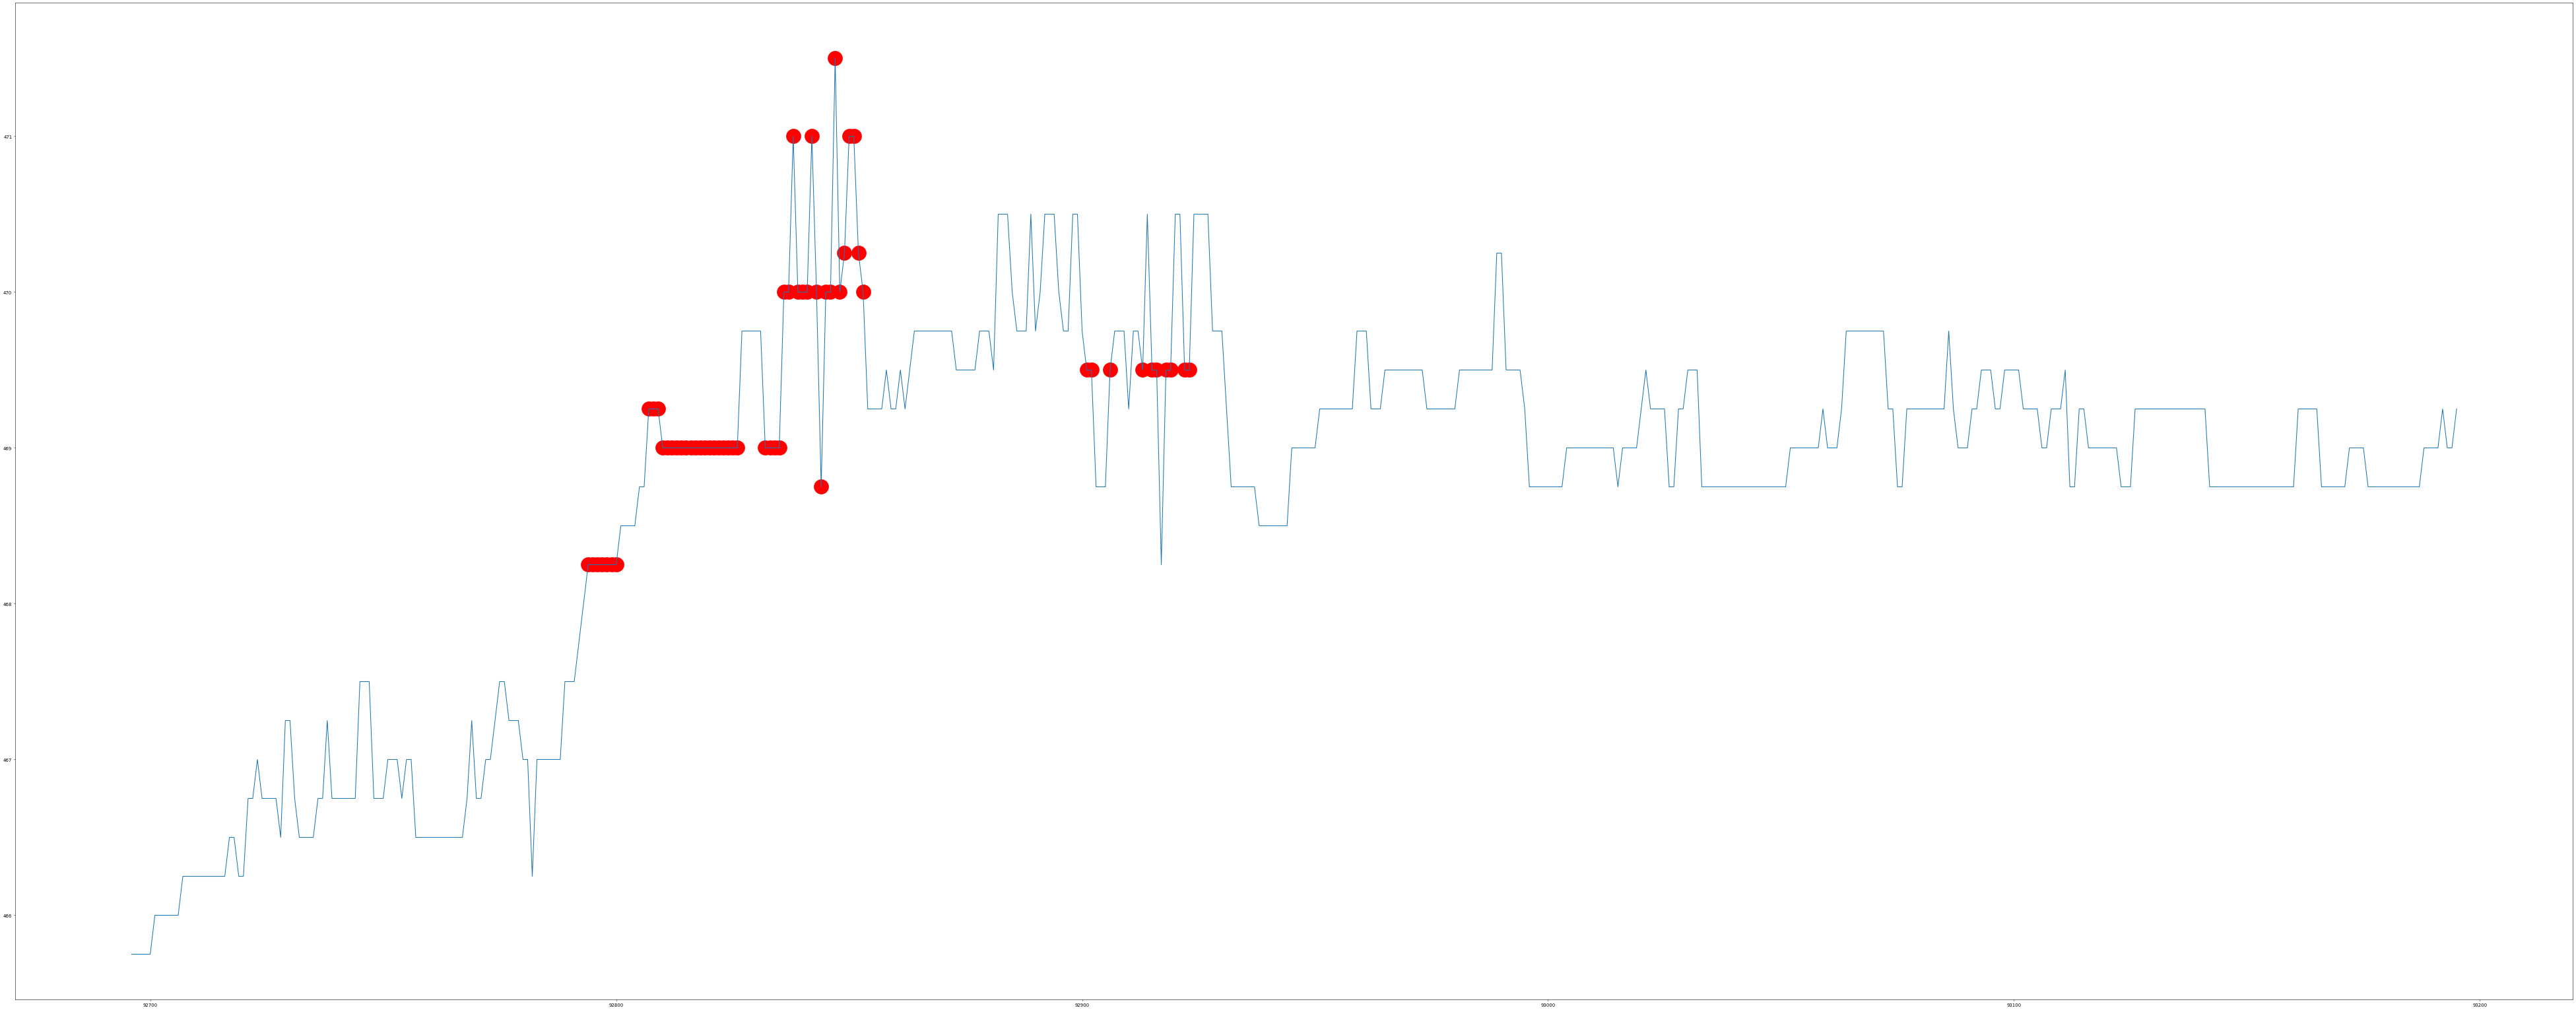

In [143]:
df_test_ = df_test[df_test.TxTime == '2020-05-04'].iloc[:500]
plt.figure(figsize=(100,40),dpi=50)
plt.plot(df_test_['mid1'])
plt.scatter(df_test_[df_test_['p_acc_diff'] > 25].index.tolist(), df_test_['mid1'][df_test_[df_test_['p_acc_diff'] > 25].index.tolist()], color = ['red'], s = 1000)

# strategy

In [23]:
paras = ['p_acc_diff']

In [24]:
#train
transaction_history1 = {}
equity_value_1 = pd.DataFrame()
each_return1 = pd.DataFrame()
unrealized_1 = pd.DataFrame()
date_idx = df_train['TxTime'].unique()
#紀錄已實現
equity_value1 = pd.DataFrame()
#紀錄未實現
unrealized1 = pd.DataFrame()
for k in date_idx:
    df = df_train[df_train.TxTime == k]
    for i in range(len(df)):
        #first tick, no signal
        if i == 0:
            df['holding'].iloc[i] = 0
            df['equity_value'].iloc[i] = 0
        #last tick
        elif i == (len(df) - 1):
            if df['holding'].iloc[i-1] == 1:
                df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) - 0.0015
                df['unrealized'].iloc[i] = 'realized'
                transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
            #ask1 may be 0, which means 漲停 (買不到)
            elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) * (-1)
                df['unrealized'].iloc[i] = 'realized'
                transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
            elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) * (-1)
                df['unrealized'].iloc[i] = 'realized'
                transaction_history1 = record_transaction(paras[0], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
            else:
                df['equity_value'].iloc[i] = 0
        else:
            if df['holding'].iloc[i-1] == 1:
                #change side
                if (df['action'].iloc[i-1] == -1): 
                    df['holding'].iloc[i] = -1
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) - (0.0015 * 2)
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                    transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    df['holding'].iloc[i] = df['holding'].iloc[i-1]
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
            elif df['holding'].iloc[i-1] == -1:
                #change side
                if (df['Ask1'].iloc[i] != 0) and (df['action'].iloc[i-1] == 1): 
                    df['holding'].iloc[i] = 1
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[0]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                else:
                    df['holding'].iloc[i] = df['holding'].iloc[i-1]
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
            elif df['holding'].iloc[i-1] == 0:
                if (df['action'].iloc[i-1] == 1) and (df['Ask1'].iloc[i] != 0):
                    df['holding'].iloc[i] = 1
                    df['equity_value'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif df['action'].iloc[i-1] == -1:
                    df['holding'].iloc[i] = -1
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
    equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
    unrealized1 = pd.concat([unrealized1, df['unrealized']])
#concat
equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
#MA(50)
performance(equity_value_1[['equity_value']], transaction_history1['p_acc_diff'])

return: 0.012700692967345311
std: 0.038038033165662226
sharp ratio: 0.19718929563677737
trades: 39.0
odds ratio: 0.23076923076923078
mdd: 0.12336437611373346
skewness: 0.12658407865357843


(0.012700692967345311,
 0.038038033165662226,
 0.19718929563677737,
 39.0,
 0.23076923076923078,
 0.12336437611373346,
 0.12658407865357843)

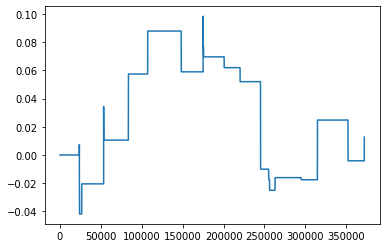

In [26]:
plt.plot(equity_value_1[['equity_value']])

In [145]:
df_train.TxTime.unique()

array(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-06', '2020-04-07',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-20', '2020-04-21', '2020-04-22'], dtype=object)

In [146]:
df_test.TxTime.unique()

array(['2020-04-23', '2020-04-24', '2020-04-27', '2020-04-28',
       '2020-04-29', '2020-04-30', '2020-05-04', '2020-05-05'],
      dtype=object)

In [104]:
#test
transaction_history2 = {}
equity_value_2 = pd.DataFrame()
each_return2 = pd.DataFrame()
unrealized_2 = pd.DataFrame()
date_idx = df_test['TxTime'].unique()
#紀錄已實現
equity_value2 = pd.DataFrame()
#紀錄未實現
unrealized2 = pd.DataFrame()
for k in date_idx:
    df = df_test[df_test.TxTime == k]
    for i in range(len(df)):
        #first tick, no signal
        if i == 0:
            df['holding'].iloc[i] = 0
            df['equity_value'].iloc[i] = 0
        #last tick
        elif i == (len(df) - 1):
            if df['holding'].iloc[i-1] == 1:
                df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[0]][-1]['Price'] - 1) - 0.0015
                df['unrealized'].iloc[i] = 'realized'
                transaction_history2 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
            #ask1 may be 0, which means 漲停 (買不到)
            elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[0]][-1]['Price'] - 1) * (-1)
                df['unrealized'].iloc[i] = 'realized'
                transaction_history2 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                #收盤如果漲停，空單結不掉，先用mid1結
            elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history2[paras[0]][-1]['Price'] - 1) * (-1)
                df['unrealized'].iloc[i] = 'realized'
                transaction_history2 = record_transaction(paras[0], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
            else:
                df['equity_value'].iloc[i] = 0
        else:
            if df['holding'].iloc[i-1] == 1:
                #hard stop 1 -1 = 0 -> 0
                #if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                #    df['holding'].iloc[i] = 0
                #    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                #    df['unrealized'].iloc[i] = 'realized'
                #    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #change side 1 -2 -> -1
                if (df['action'].iloc[i-1] == -1): 
                    df['holding'].iloc[i] = -1
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history2[paras[0]][-1]['Price'] - 1) - (0.0015 * 2)
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history2 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history2)
                    transaction_history2 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    df['holding'].iloc[i] = df['holding'].iloc[i-1]
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1)
            elif df['holding'].iloc[i-1] == -1:
                #hard stop -1 +1 -> 0
                #if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                #    df['holding'].iloc[i] = 0
                #    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                #    df['unrealized'].iloc[i] = 'realized'
                #    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #change side -1 +2 -> 1
                if (df['Ask1'].iloc[i] != 0) and (df['action'].iloc[i-1] == 1): 
                    df['holding'].iloc[i] = 1
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history2[paras[0]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = 'realized'
                    transaction_history2 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history2)
                    transaction_history2 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                else:
                    df['holding'].iloc[i] = df['holding'].iloc[i-1]
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1)
            elif df['holding'].iloc[i-1] == 0:
                if (df['action'].iloc[i-1] == 1) and (df['Ask1'].iloc[i] != 0):
                    df['holding'].iloc[i] = 1
                    df['equity_value'].iloc[i] = 0
                    transaction_history2 = record_transaction(paras[0], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history2)
                elif df['action'].iloc[i-1] == -1:
                    df['holding'].iloc[i] = -1
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history2 = record_transaction(paras[0], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history2)
                else:
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
    equity_value2 = pd.concat([equity_value2, df[['equity_value']]])
    unrealized2 = pd.concat([unrealized2, df['unrealized']])
#concat
equity_value_2 = pd.concat([equity_value_2, np.cumsum(equity_value2)], axis = 1)
each_return2 = pd.concat([each_return2, equity_value2], axis = 1)
unrealized_2 = pd.concat([unrealized_2, unrealized2], axis = 1)

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda

In [105]:
#try > 23
equity_value_2

,equity_value
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
121131,-0.055757
121132,-0.055757
121133,-0.055757
121134,-0.055757


In [106]:
performance(equity_value_2[['equity_value']], transaction_history2['p_acc_diff'])

return: -0.05575744745052234
std: 0.018816739679785036
sharp ratio: -3.2395329099445096
trades: 8.0
odds ratio: 0.0
mdd: 0.05575744745052234
skewness: -0.6826854951244924


(-0.05575744745052234,
 0.018816739679785036,
 -3.2395329099445096,
 8.0,
 0.0,
 0.05575744745052234,
 -0.6826854951244924)

In [107]:
transaction_history2['p_acc_diff']

[{'Date': '2020-04-24',
  'tick': 505,
  'Action': 1,
  'Price': 436.0,
  'Equity_value': 0},
 {'Date': '2020-04-24',
  'tick': 13517,
  'Action': -1,
  'Price': 429.5,
  'Equity_value': -0.01640825688073394},
 {'Date': '2020-04-28',
  'tick': 3,
  'Action': 1,
  'Price': 452.0,
  'Equity_value': 0},
 {'Date': '2020-04-28',
  'tick': 14204,
  'Action': -1,
  'Price': 451.0,
  'Equity_value': -0.0037123893805309214},
 {'Date': '2020-05-04',
  'tick': 12,
  'Action': 1,
  'Price': 467.0,
  'Equity_value': 0},
 {'Date': '2020-05-04',
  'tick': 99,
  'Action': -1,
  'Price': 467.5,
  'Equity_value': -0.0004293361884368228},
 {'Date': '2020-05-04',
  'tick': 99,
  'Action': -1,
  'Price': 467.5,
  'Equity_value': -0.0015},
 {'Date': '2020-05-04',
  'tick': 206,
  'Action': 1,
  'Price': 471.0,
  'Equity_value': -0.007486631016042855},
 {'Date': '2020-05-04',
  'tick': 206,
  'Action': 1,
  'Price': 471.0,
  'Equity_value': 0},
 {'Date': '2020-05-04',
  'tick': 212,
  'Action': -1,
  'Price'

In [113]:
equity_value_2, transaction_history2, each_return2, unrealized_2 = strategy(df_test, 'action')

C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\Anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

In [114]:
equity_value_2

,equity_value
0,0.00000
1,0.00000
2,0.00000
3,0.00000
4,0.00000
...,...
121032,-0.01261
121033,-0.01261
121034,-0.01261
121035,-0.01261


In [115]:
transaction_history2

{'a': [{'Date': '2020-05-04',
   'tick': 99,
   'Action': -1,
   'Price': 467.5,
   'Equity_value': -0.0015},
  {'Date': '2020-05-04',
   'tick': 206,
   'Action': 1,
   'Price': 471.0,
   'Equity_value': -0.007486631016042855},
  {'Date': '2020-05-04',
   'tick': 206,
   'Action': 1,
   'Price': 471.0,
   'Equity_value': 0},
  {'Date': '2020-05-04',
   'tick': 14172,
   'Action': -1,
   'Price': 470.0,
   'Equity_value': -0.003623142250530785}]}